In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, NaiveBayes, RandomForestClassifier, GBTClassifier
from pyspark.sql.functions import col

In [3]:
spark = SparkSession.builder.appName("SpamClassifierWithPlots").getOrCreate()


In [4]:
sms_data = spark.read.csv('/content/spam.csv' , header=True, inferSchema=True)

In [5]:
sms_data.show(5)

+----+--------------------+----+----+----+
|  v1|                  v2| _c2| _c3| _c4|
+----+--------------------+----+----+----+
| ham|Go until jurong p...|NULL|NULL|NULL|
| ham|Ok lar... Joking ...|NULL|NULL|NULL|
|spam|Free entry in 2 a...|NULL|NULL|NULL|
| ham|U dun say so earl...|NULL|NULL|NULL|
| ham|Nah I don't think...|NULL|NULL|NULL|
+----+--------------------+----+----+----+
only showing top 5 rows



In [6]:
sms_data.columns


['v1', 'v2', '_c2', '_c3', '_c4']

In [7]:
# Drop the specified columns
sms_data = sms_data.drop('_c2', '_c3', '_c4')


In [8]:
sms_data.show(5)

+----+--------------------+
|  v1|                  v2|
+----+--------------------+
| ham|Go until jurong p...|
| ham|Ok lar... Joking ...|
|spam|Free entry in 2 a...|
| ham|U dun say so earl...|
| ham|Nah I don't think...|
+----+--------------------+
only showing top 5 rows



In [9]:
sms_data = sms_data.withColumnRenamed('v1', 'output').withColumnRenamed('v2', 'input')

In [10]:
sms_data.columns

['output', 'input']

In [11]:
sms_data.groupBy('output').count().show()

+------+-----+
|output|count|
+------+-----+
|ham"""|    2|
|   ham| 4825|
|  spam|  747|
+------+-----+



In [12]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [13]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType
from pyspark.ml.feature import CountVectorizer
from pyspark.sql.functions import split
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [14]:
#spark = SparkSession.builder.appName("TextProcessing").getOrCreate()

In [15]:
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()


In [16]:
def cleaned_data(text):
    if text is None or text == '':
        return ''
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower().split()
    text = [ps.stem(word) for word in text if word not in stop_words]
    return ' '.join(text)

In [17]:
sms_data = sms_data.withColumn("input", col("input").cast("string"))


In [18]:
clean_text_udf = udf(cleaned_data, StringType())

In [19]:
data = sms_data.withColumn("cleaned_input", clean_text_udf(col("input")))

In [20]:
data.select('input', 'cleaned_input').show(5, truncate=False)


+-----------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------+
|input                                                                                                                                                      |cleaned_input                                                                                      |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------+
|Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...                                            |go jurong point crazi avail bugi n great world la e buffet cine got a

In [21]:
data = data.withColumn('words', split(data.cleaned_input, ' '))

In [22]:
bagofwords_vectors = CountVectorizer(inputCol='words', outputCol='features', vocabSize=10000, minDF=5.0)
vectorized_data = bagofwords_vectors.fit(data).transform(data)

In [23]:
vectorized_data.select('input', 'cleaned_input', 'features').show(5, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------+
|input                                                                                                                                                      |cleaned_input                                                                                      |features                                                                                                                                     |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------

In [24]:
from pyspark.sql.functions import when
vectorized_data = vectorized_data.withColumn("label", when(col("output") == "spam", 1).otherwise(0))


In [25]:
response_var = vectorized_data.select("features").head()[0].toArray()

In [26]:
print(response_var )

[0. 0. 1. ... 0. 0. 0.]


In [35]:
from pyspark.sql.functions import col
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.sql import functions as F
from sklearn.neighbors import KNeighborsClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split
import pandas as pd
train_data, test_data = vectorized_data.randomSplit([0.8, 0.2], seed=42)


Classification Report
Accuracy: 0.980
Sensitivity (Recall): 0.905
Specificity: 0.992
AUC: 0.9836


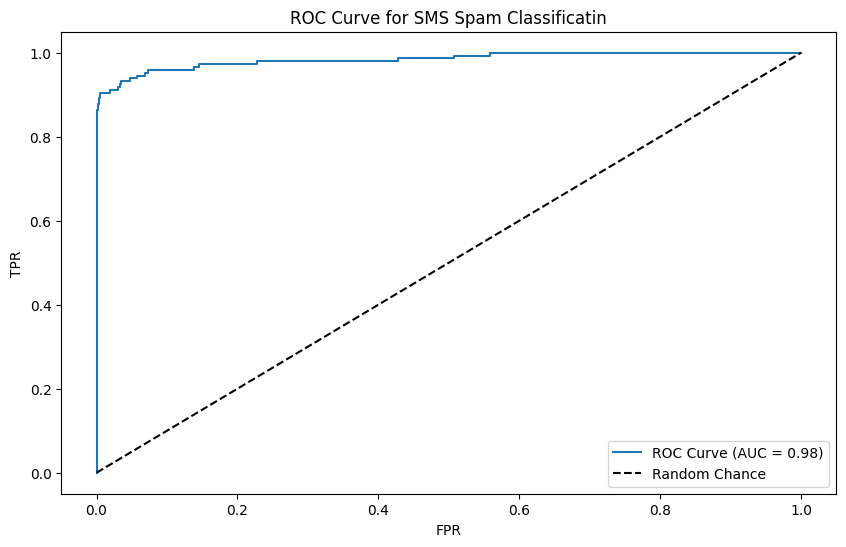

In [28]:
#Multinomial model
multinomial_nb = NaiveBayes(featuresCol='features', labelCol='label', modelType="multinomial")
nb_model = multinomial_nb.fit(train_data)

test_predict = nb_model.transform(test_data)

y_pred = test_predict.select("prediction", "label").rdd.map(lambda row: (row[0], row[1])).collect()
y_pred_labels, y_true = zip(*y_pred)

tn, fp, fn, tp = confusion_matrix(y_true, y_pred_labels).ravel()

acc = (tp + tn) / (tp + tn + fp + fn)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Classification Report")
print(f"Accuracy: {acc:.3f}")
print(f"Sensitivity (Recall): {recall:.3f}")
print(f"Specificity: {specificity:.3f}")

# Calculate probabilities for ROC curve
y_probabilites = test_predict.select("probability").rdd.map(lambda r: r[0][1]).collect()
fpr, tpr, thresholds = roc_curve(y_true, y_probabilites)
roc_auc_data = roc_auc_score(y_true, y_probabilites)

print(f"AUC: {roc_auc_data:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_data:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve for SMS Spam Classificatin')
plt.legend()
plt.show()


Classification Report
Accuracy: 0.9356
Sensitivity (Recall): 0.5306
Specificity: 1.0000
AUC: 0.9804


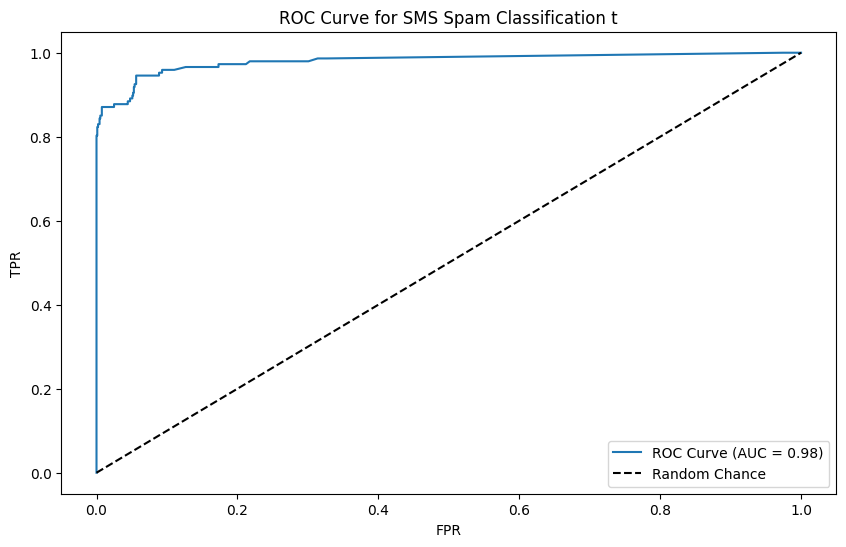

In [29]:

model_rf = RandomForestClassifier(featuresCol='features', labelCol='label', numTrees=100, maxDepth=10, seed=42)
model_rf = model_rf.fit(train_data)

test_predicts = model_rf.transform(test_data)

y_pred = test_predicts.select("prediction", "label").rdd.map(lambda r: (r[0], r[1])).collect()
y_pred_labels, y_true = zip(*y_pred)

tn, fp, fn, tp = confusion_matrix(y_true, y_pred_labels).ravel()

accu = (tp + tn) / (tp + tn + fp + fn)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Classification Report")
print(f"Accuracy: {accu:.4f}")
print(f"Sensitivity (Recall): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")


y_probabilites = test_predicts.select("rawPrediction").rdd.map(lambda r: r[0][1] / (r[0][0] + r[0][1])).collect()
roc_auc_data = roc_auc_score(y_true, y_probabilites)
print(f"AUC: {roc_auc_data:.4f}")

fpr, tpr, thresholds = roc_curve(y_true, y_probabilites)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_data:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve for SMS Spam Classification t')
plt.legend()
plt.show()


Classification Report
Accuracy: 0.9757
Sensitivity (Recall): 0.8367
Specificity: 0.9978
AUC: 0.9894


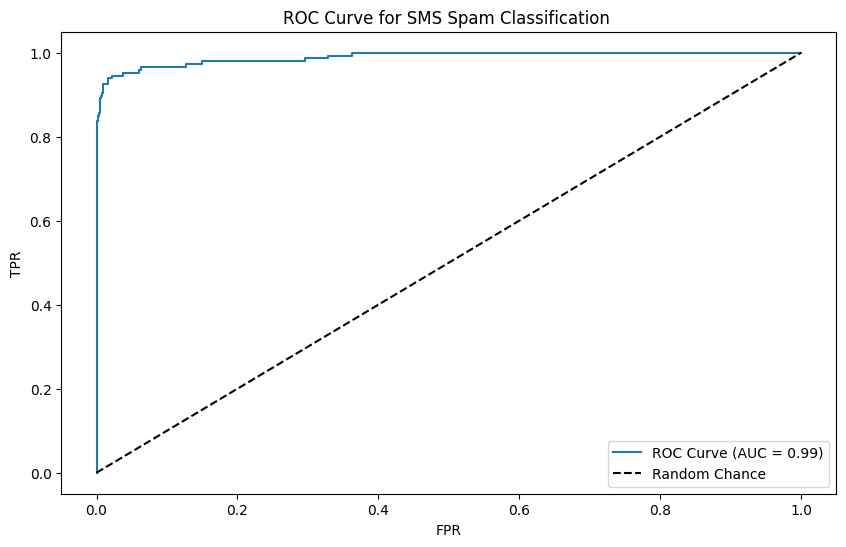

In [30]:
model_svc = LinearSVC(featuresCol='features', labelCol='label', maxIter=100, regParam=0.1)
model_svc = model_svc.fit(train_data)

test_predicts = model_svc.transform(test_data)

y_pred = test_predicts.select("prediction", "label").rdd.map(lambda r: (r[0], r[1])).collect()
y_pred_labels, y_true = zip(*y_pred)

tn, fp, fn, tp = confusion_matrix(y_true, y_pred_labels).ravel()

acc = (tp + tn) / (tp + tn + fp + fn)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Classification Report")
print(f"Accuracy: {acc:.4f}")
print(f"Sensitivity (Recall): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")

y_raw_data = test_predicts.select("rawPrediction").rdd.map(lambda r: r[0][1]).collect()
roc_auc_data = roc_auc_score(y_true, y_raw_data)
print(f"AUC: {roc_auc_data:.4f}")

fpr, tpr, thresholds = roc_curve(y_true, y_raw_data)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_data:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve for SMS Spam Classification ')
plt.legend()
plt.show()


Classification Report
Accuracy: 0.9729
Sensitivity (Recall): 0.8027
Specificity: 1.0000


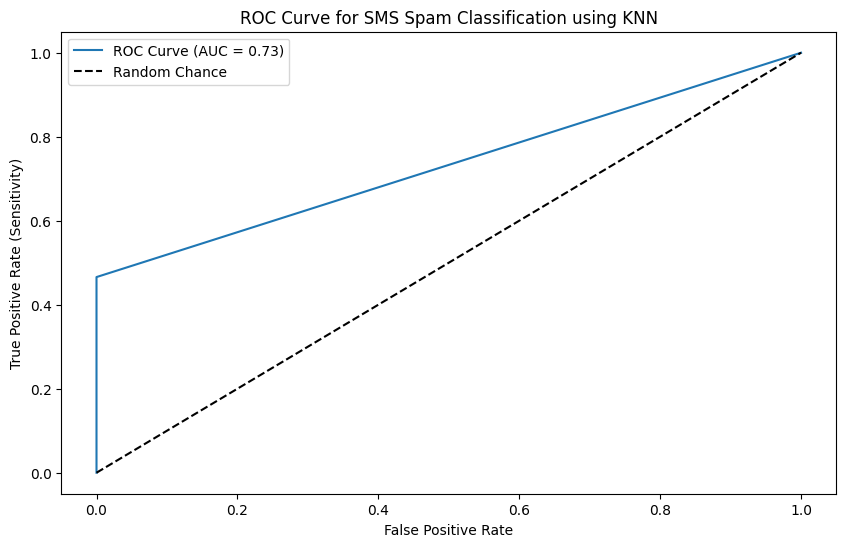

In [36]:

vectorized_data_pd = vectorized_data.select("features", "output").toPandas()
X = vectorized_data_pd['features'].apply(lambda x: x.toArray()).to_list()
X = pd.DataFrame(X)
y = vectorized_data_pd['output'].apply(lambda x: 1 if x == "spam" else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# Calculate metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn)  # Recall or True Positive Rate
specificity = tn / (tn + fp)

# Print metrics
print("Classification Report")
print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve for SMS Spam Classification using KNN')
plt.legend()
plt.show()


Classification Report
Accuracy: 0.9729
Sensitivity (Recall): 0.8027
Specificity: 1.0000
AUC: 0.9920


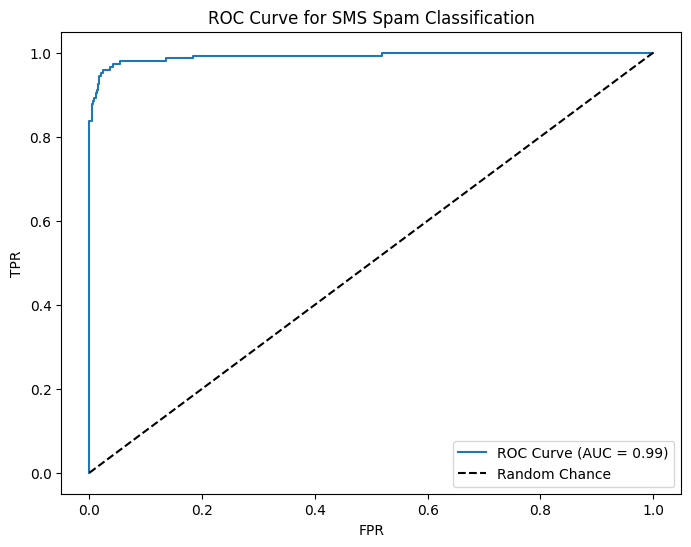

In [33]:

model_lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=100, regParam=0.1)
model_lr = model_lr.fit(train_data)

test_predicts = model_lr.transform(test_data)

y_pred = test_predicts.select("prediction", "label").rdd.map(lambda r: (r[0], r[1])).collect()
y_pred_labels, y_true = zip(*y_pred)

tn, fp, fn, tp = confusion_matrix(y_true, y_pred_labels).ravel()

accu = (tp + tn) / (tp + tn + fp + fn)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Classification Report")
print(f"Accuracy: {accu:.4f}")
print(f"Sensitivity (Recall): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")

y_raw_data = test_predicts.select("rawPrediction").rdd.map(lambda r: r[0][1]).collect()
roc_auc_data = roc_auc_score(y_true, y_raw_data)
print(f"AUC: {roc_auc_data:.4f}")

fpr, tpr, thresholds = roc_curve(y_true, y_raw_data)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_data:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve for SMS Spam Classification')
plt.legend()
plt.show()



